In [1]:
import scipy.io
import scipy.io
import anndata
import pandas as pd
import numpy as np

In [2]:
import networkx as nx
import scanpy as sc
import scglue
from matplotlib import rcParams
from itertools import chain
import itertools
import seaborn as sns

/dssg/home/acct-clswt/clswt-chaodeng/miniconda3/envs/glue/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sparse_matrix = scipy.io.mmread("data/rna_sparse_matrix.mtx")
sparse_matrix = scipy.sparse.csr_matrix(sparse_matrix)

In [4]:
gene_names = pd.read_csv("data/gene_names.csv", header=None)[1].tolist()
cell_names = pd.read_csv("data/cell_names.csv", header=None)[1].tolist()
gene_names = gene_names[1:]
cell_names = cell_names[1:]

In [5]:
rna_adata = anndata.AnnData(sparse_matrix.T)
rna_adata.var_names = gene_names
rna_adata.obs_names = cell_names

In [6]:
rna_adata.layers["counts"] = rna_adata.X.copy()

/dssg/home/acct-clswt/clswt-chaodeng/miniconda3/envs/glue/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


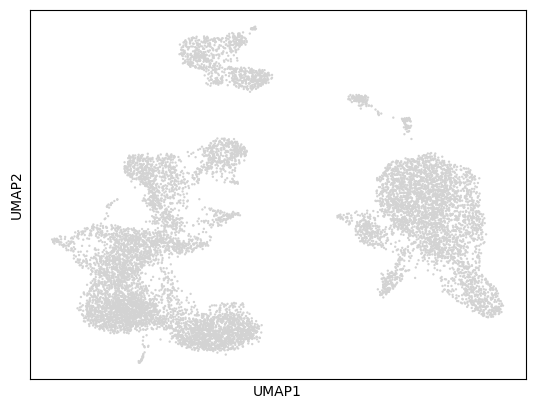

In [7]:
sc.pp.highly_variable_genes(rna_adata, n_top_genes=2000, flavor="seurat_v3")
sc.pp.normalize_total(rna_adata)
sc.pp.log1p(rna_adata)
sc.pp.scale(rna_adata)
sc.tl.pca(rna_adata, n_comps=50, svd_solver="auto")
sc.pp.neighbors(rna_adata, n_pcs=50)
sc.tl.umap(rna_adata)
sc.pl.umap(rna_adata)

In [8]:
atac_matrix = scipy.io.mmread("data/atac_sparse_matrix.mtx")
atac_matrix = scipy.sparse.csr_matrix(atac_matrix)
peak_names = pd.read_csv("data/peak_names.csv", header=None)[1].tolist()
cell_names = pd.read_csv("data/atac_cell_names.csv", header=None)[1].tolist()
peak_names = peak_names[1:]
cell_names = cell_names[1:]

In [9]:
atac_adata = anndata.AnnData(atac_matrix.T)
# 设置行和列名
atac_adata.var_names = peak_names
atac_adata.obs_names = cell_names

/dssg/home/acct-clswt/clswt-chaodeng/miniconda3/envs/glue/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


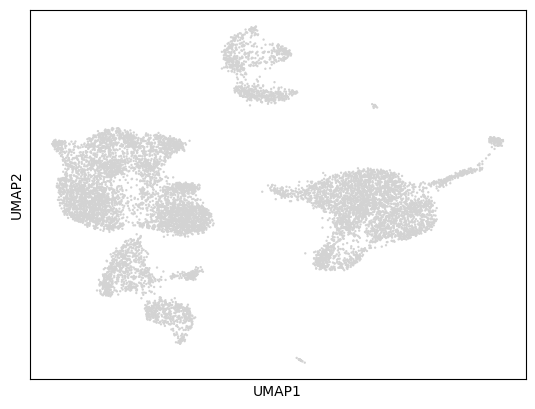

In [10]:
scglue.data.lsi(atac_adata, n_components=50, n_iter=15)
sc.pp.neighbors(atac_adata, use_rep="X_lsi", n_pcs=50)
sc.tl.umap(atac_adata)
sc.pl.umap(atac_adata)

In [11]:
scglue.data.get_gene_annotation(
    rna_adata, gtf="/dssg/home/acct-clswt/clswt-chaodeng/refdata-gex-GRCh38-2020-A/genes/genes.gtf",
    gtf_by="gene_name")

In [12]:
rna_adata.var.loc[:, ["chrom", "chromStart", "chromEnd"]]

,chrom,chromStart,chromEnd
MIR1302-2HG,chr1,29553.0,31109.0
FAM138A,chr1,34553.0,36081.0
OR4F5,chr1,65418.0,71585.0
AL627309.1,chr1,89294.0,133723.0
AL627309.3,chr1,89550.0,91105.0
...,...,...,...
AC141272.1,KI270728.1,1270983.0,1271271.0
AC023491.2,KI270731.1,10597.0,13001.0
AC007325.1,KI270734.1,72410.0,74814.0
AC007325.4,KI270734.1,131493.0,137392.0


In [13]:
split = atac_adata.var_names.str.split(r"[:-]")
atac_adata.var["chrom"] = split.map(lambda x: x[0])
atac_adata.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
atac_adata.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
atac_adata.var.head()


,chrom,chromStart,chromEnd
chr1-9790-10675,chr1,9790,10675
chr1-180599-181702,chr1,180599,181702
chr1-191168-192093,chr1,191168,192093
chr1-267565-268455,chr1,267565,268455
chr1-270876-271770,chr1,270876,271770


In [14]:
rna_adata.var = rna_adata.var.fillna(0)  ###filter NA
rna_adata.var.loc[~rna_adata.var['strand'].isin(['+', '-']), 'strand'] = '+'

In [15]:
guidance = scglue.genomics.rna_anchored_guidance_graph(rna_adata, atac_adata)
guidance

window_graph: 100%|██████████| 36601/36601 [00:02<00:00, 17080.52it/s]


In [16]:
scglue.graph.check_graph(guidance, [rna_adata, atac_adata])

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


In [17]:
atac_adata.var.head()

,chrom,chromStart,chromEnd,highly_variable
chr1-9790-10675,chr1,9790,10675,False
chr1-180599-181702,chr1,180599,181702,False
chr1-191168-192093,chr1,191168,192093,False
chr1-267565-268455,chr1,267565,268455,False
chr1-270876-271770,chr1,270876,271770,False


In [18]:
scglue.models.configure_dataset(
rna_adata, "NB", use_highly_variable=True,
use_layer="counts", use_rep="X_pca")
scglue.models.configure_dataset(
atac_adata, "NB", use_highly_variable=True,
use_rep="X_lsi")
    
guidance_hvf = guidance.subgraph(chain(
rna_adata.var.query("highly_variable").index,
atac_adata.var.query("highly_variable").index)).copy()
    
glue = scglue.models.fit_SCGLUE(
    {"rna": rna_adata, "atac": atac_adata}, guidance_hvf,
    fit_kws={"directory": "glue"})
dx = scglue.models.integration_consistency(
    glue, {"rna": rna_adata, "atac": atac_adata}, guidance_hvf)
    
rna_adata.obsm["X_glue"] = glue.encode_data("rna", rna_adata)
atac_adata.obsm["X_glue"] = glue.encode_data("atac", atac_adata)
combined = anndata.concat([rna_adata, atac_adata])
    
combined.obs['domain'] = ''
num = int(combined.obs.shape[0]/2)
combined.obs.iloc[:num, combined.obs.columns.get_loc('domain')] = 'RNA'
combined.obs.iloc[num+1:, combined.obs.columns.get_loc('domain')] = 'ATAC'


[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] autodevice: Using CPU as computation device.
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 21247
[INFO] SCGLUEModel: Setting `max_epochs` = 163
[INFO] SCGLUEModel: Setting `patience` = 14
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 7
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"


/dssg/home/acct-clswt/clswt-chaodeng/miniconda3/envs/glue/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.476, 'g_kl': 0.009, 'g_elbo': 0.485, 'x_rna_nll': 0.304, 'x_rna_kl': 0.009, 'x_rna_elbo': 0.313, 'x_atac_nll': 0.194, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.196, 'dsc_loss': 0.688, 'vae_loss': 0.528, 'gen_loss': 0.493}, val={'g_nll': 0.473, 'g_kl': 0.009, 'g_elbo': 0.482, 'x_rna_nll': 0.306, 'x_rna_kl': 0.009, 'x_rna_elbo': 0.315, 'x_atac_nll': 0.195, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.197, 'dsc_loss': 0.689, 'vae_loss': 0.53, 'gen_loss': 0.496}, 13.2s elapsed
[INFO] SCGLUETrainer: [Epoch 20] train={'g_nll': 0.456, 'g_kl': 0.009, 'g_elbo': 0.466, 'x_rna_nll': 0.299, 'x_rna_kl': 0.009, 'x_rna_elbo': 0.308, 'x_atac_nll': 0.189, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.191, 'dsc_loss': 0.69, 'vae_loss': 0.517, 'gen_loss': 0.483}, val={'g_nll': 0.455, 'g_kl': 0.009, 'g_elbo': 0.464, 'x_rna_nll': 0.305, 'x_rna_kl': 0.009, 'x_rna_elbo': 0.314, 'x_atac_nll': 0.193, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.194, 'dsc_loss': 0.692, 'vae_loss': 0.527, 'g

2025-07-09 20:51:57,599 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "46"...
[INFO] EarlyStopping: Restoring checkpoint "46"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (19, 29)...
[INFO] estimate_balancing_weight: Estimating balancing weight...


/dssg/home/acct-clswt/clswt-chaodeng/miniconda3/envs/glue/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/dssg/home/acct-clswt/clswt-chaodeng/miniconda3/envs/glue/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 21247
[INFO] SCGLUEModel: Setting `align_burnin` = 28
[INFO] SCGLUEModel: Setting `max_epochs` = 163
[INFO] SCGLUEModel: Setting `patience` = 14
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 7
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"


/dssg/home/acct-clswt/clswt-chaodeng/miniconda3/envs/glue/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.445, 'g_kl': 0.009, 'g_elbo': 0.454, 'x_rna_nll': 0.298, 'x_rna_kl': 0.009, 'x_rna_elbo': 0.307, 'x_atac_nll': 0.188, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.189, 'dsc_loss': 0.683, 'vae_loss': 0.515, 'gen_loss': 0.48}, val={'g_nll': 0.445, 'g_kl': 0.009, 'g_elbo': 0.454, 'x_rna_nll': 0.296, 'x_rna_kl': 0.008, 'x_rna_elbo': 0.305, 'x_atac_nll': 0.187, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.188, 'dsc_loss': 0.692, 'vae_loss': 0.511, 'gen_loss': 0.476}, 20.8s elapsed
[INFO] SCGLUETrainer: [Epoch 20] train={'g_nll': 0.445, 'g_kl': 0.008, 'g_elbo': 0.453, 'x_rna_nll': 0.3, 'x_rna_kl': 0.009, 'x_rna_elbo': 0.309, 'x_atac_nll': 0.189, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.19, 'dsc_loss': 0.689, 'vae_loss': 0.517, 'gen_loss': 0.483}, val={'g_nll': 0.444, 'g_kl': 0.008, 'g_elbo': 0.452, 'x_rna_nll': 0.297, 'x_rna_kl': 0.008, 'x_rna_elbo': 0.305, 'x_atac_nll': 0.188, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.189, 'dsc_loss': 0.685, 'vae_loss': 0.513, 'gen

2025-07-09 21:12:37,960 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "66"...
[INFO] EarlyStopping: Restoring checkpoint "66"...
[INFO] integration_consistency: Using layer "counts" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "atac"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "rna"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "atac"
[INFO] get_metacells: Clustering metacells...


/dssg/home/acct-clswt/clswt-chaodeng/miniconda3/envs/glue/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md
/dssg/home/acct-clswt/clswt-chaodeng/miniconda3/envs/glue/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 10 common metacells...
[INFO] get_metacells: Clustering metacells...


/dssg/home/acct-clswt/clswt-chaodeng/miniconda3/envs/glue/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md
/dssg/home/acct-clswt/clswt-chaodeng/miniconda3/envs/glue/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 20 common metacells...
[INFO] get_metacells: Clustering metacells...


/dssg/home/acct-clswt/clswt-chaodeng/miniconda3/envs/glue/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md
/dssg/home/acct-clswt/clswt-chaodeng/miniconda3/envs/glue/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 50 common metacells...
[INFO] get_metacells: Clustering metacells...


/dssg/home/acct-clswt/clswt-chaodeng/miniconda3/envs/glue/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md
/dssg/home/acct-clswt/clswt-chaodeng/miniconda3/envs/glue/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 100 common metacells...
[INFO] get_metacells: Clustering metacells...


/dssg/home/acct-clswt/clswt-chaodeng/miniconda3/envs/glue/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md
/dssg/home/acct-clswt/clswt-chaodeng/miniconda3/envs/glue/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 200 common metacells...


/dssg/home/acct-clswt/clswt-chaodeng/miniconda3/envs/glue/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/dssg/home/acct-clswt/clswt-chaodeng/miniconda3/envs/glue/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/dssg/home/acct-clswt/clswt-chaodeng/miniconda3/envs/glue/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


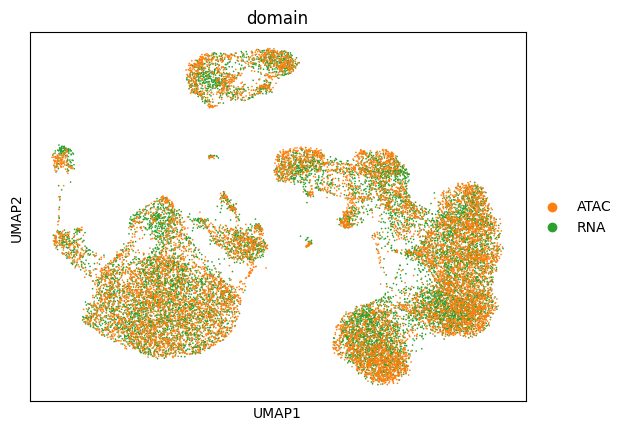

In [19]:
sc.pp.neighbors(combined, use_rep="X_glue")
sc.tl.umap(combined)
sc.pl.umap(combined, color=["domain"], wspace=0.65)

In [31]:
combined.obsm['X_umap']
combined.obs['domain'] = ''
num = int(combined.obs.shape[0]/2)
combined.obs.iloc[:num, combined.obs.columns.get_loc('domain')] = 'RNA'
combined.obs.iloc[num+1:, combined.obs.columns.get_loc('domain')] = 'ATAC'
res_df = pd.DataFrame(combined.obsm['X_umap'],index=combined.obs.index)
res_df['domain'] = combined.obs['domain']
res_df.to_csv('glue_umap.csv', index_label='RowName', header=True)

In [32]:
res_df

,0,1,domain
AAACAGCCAAGGAATC-1,13.115439,-0.767363,RNA
AAACAGCCAATCCCTT-1,17.816071,6.885480,RNA
AAACAGCCAATGCGCT-1,14.286570,1.157639,RNA
AAACAGCCACCAACCG-1,10.519529,-1.550558,RNA
AAACAGCCAGGATAAC-1,15.462269,0.114193,RNA
...,...,...,...
TTTGTTGGTGACATGC-1,11.475053,-3.233690,ATAC
TTTGTTGGTGTTAAAC-1,12.431808,-0.988775,ATAC
TTTGTTGGTTAGGATT-1,9.747090,11.540825,ATAC
TTTGTTGGTTGGTTAG-1,16.677464,4.012147,ATAC


In [37]:
res_df = pd.DataFrame(combined.obsm['X_glue'],index=combined.obs.index)
res_df['domain'] = combined.obs['domain']

In [38]:
res_df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,domain
AAACAGCCAAGGAATC-1,0.003973,-0.005414,0.017911,-0.610628,-0.642903,-0.013085,-0.000669,0.005611,1.073129,0.515145,...,1.688788,-0.011740,0.015212,0.003487,-0.016261,-0.066872,0.016338,0.450790,0.009346,RNA
AAACAGCCAATCCCTT-1,-0.013479,-0.023104,-0.000298,-0.092174,1.358469,0.001136,-0.014740,-0.016183,-0.233112,0.619989,...,1.727594,-0.001217,0.456720,0.020596,-0.007556,-0.936299,0.006502,0.049394,0.022020,RNA
AAACAGCCAATGCGCT-1,0.009342,0.008406,0.012702,0.461083,-0.684744,-0.019616,-0.000722,0.007689,0.872691,-0.791163,...,1.565977,-0.000592,0.248346,-0.027005,-0.017593,0.351735,0.025085,0.315113,-0.004421,RNA
AAACAGCCACCAACCG-1,0.005751,0.002077,-0.003502,-0.775124,-0.805618,-0.021844,0.008496,0.016336,0.503993,0.104376,...,1.491843,-0.015542,-0.915916,-0.014907,-0.015466,0.089461,0.042158,0.863485,0.003966,RNA
AAACAGCCAGGATAAC-1,0.006329,0.017397,0.013689,-0.010619,-0.436229,-0.006861,0.001140,0.010622,1.033456,-0.850196,...,1.421334,-0.006481,0.037851,-0.008256,-0.000967,0.282521,0.002121,0.048270,0.012592,RNA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGACATGC-1,-0.015337,-0.006002,0.026326,-1.356630,-0.960970,0.021518,-0.002619,-0.003239,0.739586,-0.725624,...,1.477181,0.027877,-0.148792,-0.030985,-0.005959,0.472239,-0.005136,0.099819,-0.041432,ATAC
TTTGTTGGTGTTAAAC-1,0.000104,-0.044015,0.016092,-1.361876,-0.864324,0.019352,0.012740,-0.033181,0.863662,0.022700,...,1.775263,-0.005024,0.678457,-0.001337,-0.008549,0.192141,0.000527,0.237777,-0.043673,ATAC
TTTGTTGGTTAGGATT-1,-0.023854,-0.046522,0.004486,0.666144,-1.661089,-0.054085,0.009029,-0.053902,-2.656675,-0.589522,...,0.905015,0.004450,0.310478,0.005116,0.004679,-0.800067,-0.027579,0.320248,0.003121,ATAC
TTTGTTGGTTGGTTAG-1,0.056097,0.003175,-0.008373,0.914214,0.820640,0.005596,-0.023318,0.015694,0.548983,-0.347935,...,1.368109,-0.015117,-0.002483,-0.010167,-0.001511,0.163168,0.011798,0.481635,-0.006145,ATAC


In [39]:
res_df.to_csv('glue_embed.csv', index_label='RowName', header=True)